In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPoint
import numpy as np
import shapely as shp
import matplotlib.pyplot as plt
from shapely.wkt import loads
import glob
import os
from datetime import datetime, timedelta
import netCDF4
from shapely.geometry import Point
from typing import Tuple
from scipy.interpolate import griddata
import pyproj
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import RBFInterpolator
import re
import yaml
from scipy.spatial import cKDTree
import seaborn as sns
from scipy import interpolate

In [2]:
def define_grid(bounds, n_cells, epsg, grid_type='rectangular'):
    xmin, xmax = bounds[0], bounds[2]
    ymin, ymax = bounds[1], bounds[3]

    if grid_type == 'rectangular':
        cell_size = (xmax - xmin) / n_cells
        grid_cells = []
        for x0 in np.arange(xmin, xmax, cell_size):
            for y0 in np.arange(ymin, ymax, cell_size):
                # bounds
                x1 = x0 + cell_size
                y1 = y0 + cell_size
                grid_cells.append(shp.geometry.box(x0, y0, x1, y1))
        return gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=epsg), cell_size

    elif grid_type == 'circular':
        cell_spacing = (xmax - xmin) / n_cells
        radius = cell_spacing * np.sqrt(2) / 2
        grid_cells = []
        for x_center in np.arange(xmin + radius, xmax, cell_spacing):
            for y_center in np.arange(ymin + radius, ymax, cell_spacing):
                # Create a circular cell centered at (x_center, y_center)
                cell = Point(x_center, y_center).buffer(radius)
                grid_cells.append(cell)

        # Create a GeoDataFrame from the grid cells
        return gpd.GeoDataFrame(geometry=grid_cells, crs=epsg), radius * 2

    else:
        raise ValueError("Invalid grid_type. Use 'rectangular' or 'circular'.")
        
def grid_data(gdf, grid, var, var_str, hist_n_bins=None, hist_range=None, fill_nan=False, agg_mode=None):
    if agg_mode is None:
        agg_mode = ['mean', 'std']
    tmp_grid = grid.copy()
    merged = gpd.sjoin(gdf[var + ['geometry']].copy(), grid, how='left', predicate='within')
    if 'mean' in agg_mode:
        dissolve_mean = merged.dissolve(by='index_right', aggfunc=np.mean)
        for i in range(0, len(var)):
            tmp_grid.loc[dissolve_mean.index, var_str[i]] = dissolve_mean[var[i]].values
    if 'std' in agg_mode:
        dissolve_std = merged.dissolve(by='index_right', aggfunc=np.std)
        for i in range(0, len(var)):
            tmp_grid.loc[dissolve_std.index, var_str[i] + '_std'] = dissolve_std[var[i]].values
    if 'sum' in agg_mode:
        dissolve_sum = merged.dissolve(by='index_right', aggfunc=np.sum)
        for i in range(0, len(var)):
            tmp_grid.loc[dissolve_sum.index, var_str[i] + '_sum'] = dissolve_sum[var[i]].values
    if 'cnt' in agg_mode:
        dissolve_cnt = merged.dissolve(by='index_right', aggfunc='count')
        for i in range(0, len(var)):
            tmp_grid.loc[dissolve_cnt.index, var_str[i] + '_cnt'] = dissolve_cnt[var[i]].values
    if 'hist' in agg_mode:
        dissolve_hist = merged.dissolve(by='index_right', aggfunc=np.mean)
        dissolve_hist.reset_index(inplace=True)
        dissolve_hist[var[0]] = ''
        for i in range(0, len(var)):
            for j in dissolve_hist.index_right.unique():
                tmp = merged[merged.index_right == j].drop(['index_right', 'geometry'], axis=1).reset_index(drop=True)
                tmp_hist = np.histogram(np.array(tmp[var[i]]),
                                        bins=hist_n_bins,
                                        range=(hist_range[0], hist_range[1]))[0]
                dissolve_hist[var[i]][dissolve_hist.index[dissolve_hist.index_right == j][0]] = ' '.join(
                    map(str, tmp_hist))

            tmp_grid.loc[dissolve_hist.index_right, var_str[i] + '_hist'] = dissolve_hist[var[i]].values

    if not fill_nan:
        tmp_grid = tmp_grid.dropna()

    centroidseries = tmp_grid['geometry'].centroid
    tmp_grid['x'], tmp_grid['y'] = centroidseries.x, centroidseries.y
    tmp_grid = tmp_grid.set_index(['x', 'y'])
    return tmp_grid


In [133]:
with open('/Users/rricker/GitLab/projects/DriftAware-SIAlt/config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [45]:
with open('/Users/rricker/GitLab/projects/DriftAware-SIAlt/config.yaml', 'r') as f:
    config = yaml.safe_load(f)
    
geojson_dir = config["dir"][config["options"]["sensor"]]["geojson"]
list_f = sorted(glob.glob(os.path.join(geojson_dir, f'*-f-*.geojson')))


j=0
nbs = 260  # empirical estimate
target_var = config["options"]["target_variable"]
out_epsg = config['options']['out_epsg']
stk_opt = config['options']['proc_step_options']['stacking']
start_date = stk_opt['t_start']
growth_range = stk_opt['growth_estimation']['growth_range']["freeboard" if "free" in target_var else "thickness"]
min_n_tps = stk_opt['growth_estimation']['min_n_tiepoints']
cday = start_date + timedelta(days=j)
subs = cday.strftime("%Y%m%d")
    
    
file_f = [i for i in list_f if subs in re.search('-(.+?)-*.geojson', os.path.basename(i)).group(1)]



In [60]:
def get_neighbor_dyn_range(row, data, var, tree):
    point = (row['geometry'].x, row['geometry'].y)
    neighbors_indices = tree.query_ball_point(point, row[var+'_drift_unc'], p=2.0)

    if not neighbors_indices:
        return 0.0  # Handle the case when there are no neighbors

    neighbor_thickness = data.loc[neighbors_indices, var].values
    return (np.percentile(neighbor_thickness, 75) - np.percentile(neighbor_thickness, 25))


In [2]:
data = gpd.read_file("/Volumes/data2/projects/DriftAware-SIAlt/product/envisat/geojson/sea_ice_thickness-nh-16fr-epsg6931_141-2024-01-02_19-45-39/sea_ice_thickness-envisat-nh-20080430-v100-epsg6931_141.geojson")
data['divergence'] = data['divergence'].apply(lambda x: [float(val) for val in x.split()])
data['shear'] = data['shear'].apply(lambda x: [float(val) for val in x.split()])


In [62]:
def get_deformation(row):
    mean_tot = [np.linalg.norm([a, b]) for a, b in zip(row['shear'], row['divergence'])]
    return np.mean(mean_tot), np.mean(row['shear']), np.mean(row['divergence'])

def get_row_mean(row):
    return np.mean(row)

In [64]:
div = data["divergence"].apply(get_row_mean)

In [3]:
time_bnds = np.array([[data['t0'].min(), data['t0'].max()]])


In [11]:
(time_bnds[0][1]-time_bnds[0][0])/86400

15.93797915507246

In [10]:
60*60*24

86400

In [21]:
shear=[1,2,3,4]
divergence=[5,6,7,8]
sum(np.sqrt((a ** 2 + b ** 2)) for a, b in zip(shear, divergence))

27.98361984979261

In [3]:
dt_days = np.array([-12,-6,1,3,8,14])
sit = np.array([0.9,0.76,1.2,1.0,1.22,1.18])-0.5
coeff, cov_matrix = np.polyfit(dt_days, sit, deg=1, cov=True)
#coeff_unc = np.sqrt(np.diag(coeff[1])[1])
coeff_unc = np.sqrt(cov_matrix[0, 0])

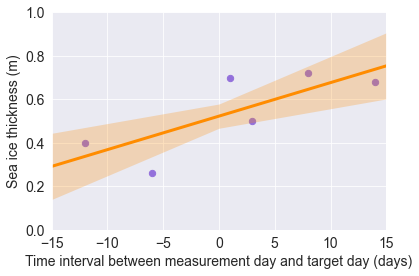

In [13]:
sns.set_style("darkgrid")
fontsize = 14
plt.scatter(dt_days,sit,s=40,color='mediumpurple')

x = np.arange(31)-15

y0_lower = x * (coeff[0]-np.sqrt(cov_matrix[0, 0])) + (coeff[1]-np.sqrt(cov_matrix[1, 1]))
y0_upper = x * (coeff[0]+np.sqrt(cov_matrix[0, 0])) + (coeff[1]+np.sqrt(cov_matrix[1, 1]))
y1_lower = x * (coeff[0]-np.sqrt(cov_matrix[0, 0])) + (coeff[1]+np.sqrt(cov_matrix[1, 1]))
y1_upper = x * (coeff[0]+np.sqrt(cov_matrix[0, 0])) + (coeff[1]-np.sqrt(cov_matrix[1, 1]))

y_lower = np.concatenate([y1_upper[0:16],y0_lower[16:]])
y_upper = np.concatenate([y1_lower[0:16],y0_upper[16:]])

plt.plot(x, x * coeff[0]+coeff[1],linewidth=3, color = 'darkorange')

#plt.plot(x, y0_lower,linewidth=3, color = 'green')
#plt.plot(x, y0_upper,linewidth=3, color = 'blue')
#plt.plot(x, y1_lower,linewidth=3, color = 'red')
#plt.plot(x, y1_upper,linewidth=3, color = 'cyan')


plt.fill_between(x, y_lower, y_upper, color='darkorange',linewidth=0, alpha=0.25)
plt.xlim(-15, 15)  
plt.ylim(0, 1) 
plt.xlabel('Time interval between measurement day and target day (days)', fontsize=fontsize)
plt.ylabel('Sea ice thickness (m)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig('/Users/rricker/Documents/projects/ESA_CCI+Phase2_option/deliverables/D3-ATBD/growth_estimation.png', bbox_inches='tight', dpi=420)